In [24]:
%matplotlib inline

In [25]:
import sys
import pandas as pd
import numpy as np
import scipy
import time
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import Levenshtein
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
import re
import csv

In [26]:
#key function

#trim guide rna bc mapping
def pandas2dict(df):

    dfdict={}

    for x,y in zip(df['guide'],df['rnabc']):
        dfdict[y[4:]]=x
    return dfdict

def edit_dist(barcodes1,barcodes2):
    dist = [[Levenshtein.distance(a,b) for a in barcodes1] for b in barcodes2]
    return np.array(dist)

def edit_dist_closest(barcode,barcodes):
    dist = [Levenshtein.distance(barcode,a) for a in barcodes]
    return np.array(dist)

def generate_random_bcs(bcs,num=100,edist=2):
    bases=['A','G','C','T']
    lenseqs=len(bcs[0])

    seqsf=[]
    curlen=0
    while (curlen<=num):
        curlen=len(seqsf)
        curseq=''.join(bases[random.randint(0,3)] for x in range(lenseqs))
        if np.min(edit_dist_closest(curseq,bcs))>=edist:
            seqsf.append(curseq)
    return seqsf

def process_cbcs(bc):
    bc['bc']=[x[0:14] for x in bc['bc']]
    bc_randos=pd.DataFrame(generate_random_bcs(bc['bc'],num=len(bc)))
    bc_randos.columns=['bc']
    bc['name']=bc['bc']
    bc_randos['name']=bc_randos['bc']
    bc=bc.set_index('bc')
    bc_randos=bc_randos.set_index('bc')
    bc=bc['name'].to_dict()
    bc_randos=bc_randos['name'].to_dict()
    return bc,bc_randos

def alignseqs(seqs,db,ed_col=2):

    count=0
    count_collapse=0
    count_multi=0

    curtable=db
    curtablelist=list(db.keys())

    lookup=[]
    lookup_collapse=[]
    unaligned=[]

    for x in seqs:
        if x in curtable:
            count+=1
            lookup.append(curtable[x])
            lookup_collapse.append(curtable[x])
        elif ed_col>0:
            lookup.append('NA')

            #calculate closest match
            distvec=edit_dist_closest(x,curtablelist)
            mindist=np.min(distvec)
            multimap=np.sum(np.array(distvec)==mindist)
            if multimap>1:
            	count_multi+=1
            	lookup_collapse.append('NA')
            elif mindist<=ed_col:
                count_collapse+=1
                lookup_collapse.append(curtable[curtablelist[np.argmin(distvec)]])
            else:
                lookup_collapse.append('NA')
                unaligned.append((x,distvec,mindist))
        else:
            lookup.append('NA')
            lookup_collapse.append('NA')
            unaligned.append((x,'NA','NA'))

    print('exact percentage',np.divide((1.0*count),len(seqs)))
    print('collapsing percentage',np.divide((1.0*count_collapse),len(seqs)))
    print('multi mapping percentage',np.divide((1.0*count_multi),len(seqs)))
    print('not in database percentage',np.min([np.mean(np.array(lookup)=='NA'),np.mean(np.array(lookup_collapse)=='NA')]))

    return lookup,lookup_collapse,unaligned

In [27]:
bc_phusion=pd.read_csv('./small_data/dialout_522_small.txt',sep='\t',header=None,names=['counts','sampbc','read'])
bc_phusion_cbc = [x[6:20] for x in bc_phusion['sampbc']]
bc_phusion_cumi = [x+'-'+y[-10:] for x,y in zip(bc_phusion_cbc,bc_phusion['read'])]

bc_phusion_rnabc=[]
for x in bc_phusion['read']:
    end_pos=re.search('CACAAGCTTAATTAAGAATT',x).end()
    bc_phusion_rnabc.append(x[end_pos:end_pos+19])

bc_phusion['cbc']=bc_phusion_cbc
bc_phusion['rnabc']=bc_phusion_rnabc
bc_phusion['cbc_umi']=bc_phusion_cumi
bc_phusion['counts']=np.array(bc_phusion['counts'])

In [28]:
bc_phusion=bc_phusion[bc_phusion['counts']>1]
print('remaining unique seqs',len(bc_phusion))

('remaining unique seqs', 20000)


In [29]:
BCUMI=bc_phusion.groupby('cbc_umi').sum()
BCUMI.columns=['cbcumi_tot']
BCUMI['cbc_umi']=BCUMI.index

In [30]:
bc_phusion=pd.merge(bc_phusion,BCUMI,on='cbc_umi')

In [31]:
bc_phusion['ratio']=((1.0*bc_phusion['counts'])/(bc_phusion['cbcumi_tot']))

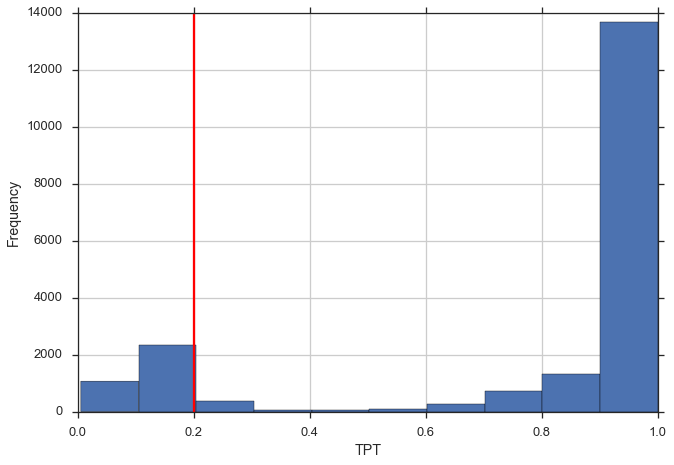

In [32]:
bc_phusion.ratio.hist()
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.axvline(0.2,c='red')

In [33]:
#filter molecules that looks like they might be potential PCR chimeras
bc_phusion_filt=bc_phusion[bc_phusion['ratio']>0.2]

In [34]:
#output path
outpath='./'

In [35]:
MAP_table=pandas2dict(pd.read_csv('./small_data/dc_pool.csv',header=None,names=['guide','rnabc']))

#align guides
lookup,lookup_col,unaligned = alignseqs(bc_phusion_filt['rnabc'],MAP_table,ed_col=4)
mindists=[z for x,y,z in unaligned]
plt.hist(mindists)
plt.ylabel('Freq')
plt.xlabel('Closest edit distance')
plt.savefig(outpath+'_unaligned_guide_closest.pdf')
plt.clf()


bc_phusion_filt['guide']=lookup
bc_phusion_filt['guide_col']=lookup_col

#align cells
print('true cell alignment')
bc,bc_randos=process_cbcs(pd.read_csv('./small_data/barcodes.tsv',sep='\t',header=None,names=['bc']))
lookup,lookup_col,unaligned = alignseqs(bc_phusion_filt['cbc'],bc,ed_col=1)
bc_phusion_filt['cell']=lookup
bc_phusion_filt['cell_col']=lookup_col

print('Total number of cells in 10x output=',len(bc.keys()))

#align random cells
#print('random cell alignment')
#lookup,lookup_col,unaligned = alignseqs(bc_phusion_filt['cbc'],bc_randos,ed_col=0)
#check unique cell barcode umi parings
#bc_phusion['nonuniqueness']=flag_nonunique(bc_phusion)

tot_reads = bc_phusion_filt['counts']
print('total reads=',np.sum(tot_reads))
#filter to "real cells and guides"
guidesNcells = np.logical_and(bc_phusion_filt['cell_col']!='NA',bc_phusion_filt['guide_col']!='NA')
bc_phusion_cells = bc_phusion_filt[guidesNcells]
print('percent of reads used for guides and cells filter = ',np.divide(1.0*np.sum(tot_reads[guidesNcells]),np.sum(tot_reads)))

('exact percentage', 0.86442718680392516)
('collapsing percentage', 0.098729757389681538)
('multi mapping percentage', 0.01757871290108964)
('not in database percentage', 0.036843055806393354)
true cell alignment
('exact percentage', 0.80789838059117447)

/Users/atray/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/atray/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/atray/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable


('collapsing percentage', 0.0048160857263259286)
('multi mapping percentage', 0.096141111311781352)
('not in database percentage', 0.18728553368249956)
('Total number of cells in 10x output=', 4771)
('total reads=', 1159290)
('percent of reads used for guides and cells filter = ', 0.78452156061037359)


/Users/atray/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
bc_phusion_cells_col = bc_phusion_cells.copy()
bc_phusion_cells_col['umicount']=[1]*len(bc_phusion_cells_col)
bc_phusion_cells_col['cbcguide']=list(zip(bc_phusion_cells_col['cell_col'],bc_phusion_cells_col['guide_col']))
BC_PHUSION_F=bc_phusion_cells_col.groupby('cbcguide').sum()
BC_PHUSION_F['cbc']=[x[0] for x in BC_PHUSION_F.index]
BC_PHUSION_F['guide']=[x[1] for x in BC_PHUSION_F.index]
#calculate per cell frequencies

In [37]:
CELL_percentage=pd.DataFrame(BC_PHUSION_F.groupby('cbc').sum()['counts'])
CELL_percentage.columns=['cell_counts']
CELL_percentage['cbc']=CELL_percentage.index

In [38]:
BC_PHUSION_FF=pd.merge(BC_PHUSION_F,CELL_percentage,on='cbc')

In [39]:
BC_PHUSION_FF['cellratio']=(1.0*BC_PHUSION_FF['counts'])/(BC_PHUSION_FF['cell_counts'])

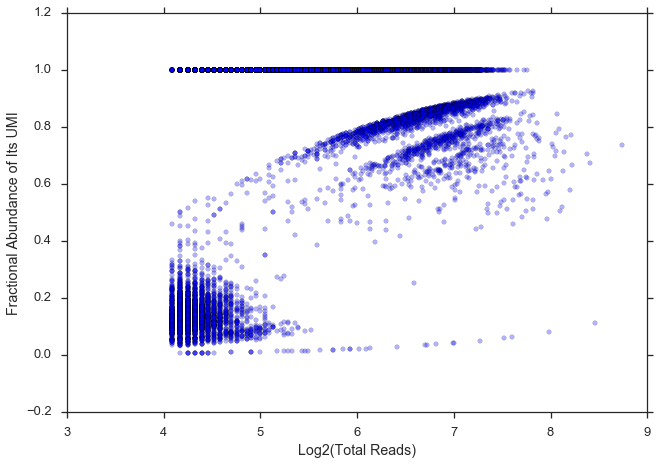

In [40]:
plt.scatter(np.log2(bc_phusion['counts']),bc_phusion['ratio'],alpha=0.3)
plt.xlabel('Log2(Total Reads)')
plt.ylabel('Fractional Abundance of Its UMI')

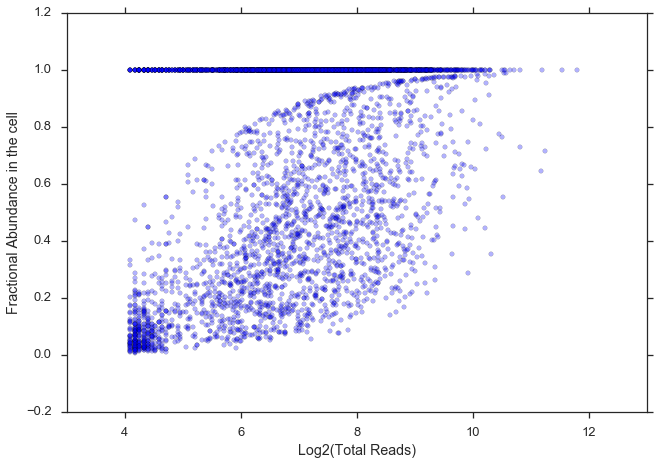

In [41]:
plt.scatter(np.log2(BC_PHUSION_FF['counts']),BC_PHUSION_FF['cellratio'],alpha=0.3)
plt.xlabel('Log2(Total Reads)')
plt.ylabel('Fractional Abundance in the cell')

In [42]:
BC_PHUSION_FF_max=BC_PHUSION_FF.groupby('cbc').max()

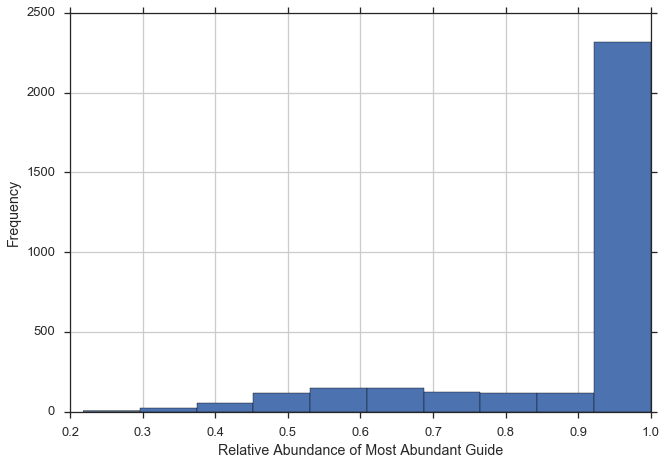

In [43]:
BC_PHUSION_FF_max.cellratio.hist()
plt.ylabel('Frequency')
plt.xlabel('Relative Abundance of Most Abundant Guide')

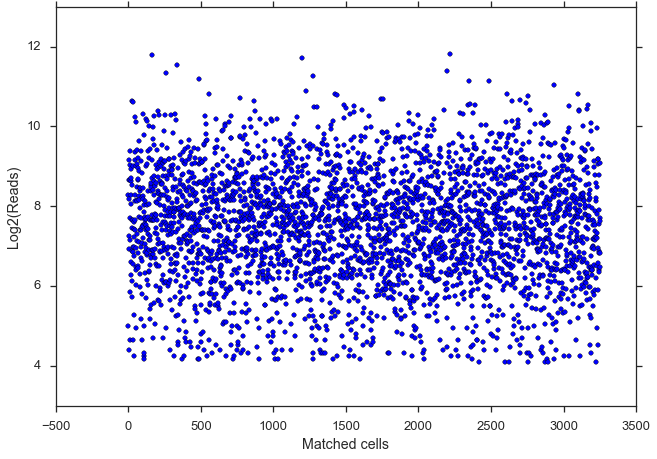

In [44]:
#plot scatter of abundance per cell
grouped_cells = bc_phusion_cells.groupby('cbc').sum()
plt.scatter(range(len(grouped_cells)),np.log2(grouped_cells['counts']))
plt.xlabel('Matched cells')
plt.ylabel('Log2(Reads)')

In [45]:
#filter to "real guides" at decent per cell frequency
cfq_filt=BC_PHUSION_F['counts']>32
bc_phusion_final = BC_PHUSION_F[cfq_filt]

guide_count=collections.Counter()
guide_count_col=collections.Counter()

guide_count.update(bc_phusion_final['guide'])
#guide_count_col.update(bc_phusion_final['guide_col'])
#likely missequenced guides
#print('Likely missequenced ',set(guide_count_col.keys())-set(guide_count.keys()))
print(guide_count)

cbcdict={}
cbcdict_reads={}
cbcdict_umi={}
curbcs=bc.keys()

for cbc in curbcs:
    cbcdict[cbc]=collections.Counter()
    cbcdict_reads[cbc]=0
    cbcdict_umi[cbc]=0

for x,y,a in zip(bc_phusion_final['cbc'],bc_phusion_final['guide'],bc_phusion_final['counts']):
    cbcdict[x].update([y])

#plt.scatter(BC_PHUSION_F['counts'],BC_PHUSION_F['umicount'])
#plt.ylabel('UMI')
#plt.xlabel('reads')
#plt.savefig(outpath+'_UMIvReads_phusion.pdf')
#plt.clf()

#calculate moi distributions
moi_list = []
guide_counter_all= collections.Counter()
guide_counter_lt5= collections.Counter()
guide_counter_moi1= collections.Counter()

final_dict_moi1={}
final_dict_all={}

for cbc in cbcdict.keys():

    valid_guides=cbcdict[cbc]

    moi_list.append(len(valid_guides))

    guide_counter_all.update(valid_guides.keys())

    if len(valid_guides)<2:
        guide_counter_moi1.update(np.unique(valid_guides.keys()))
        final_dict_moi1[cbc]=valid_guides

    if len(valid_guides)<20:
        final_dict_all[cbc]=valid_guides
        guide_counter_lt5.update(valid_guides.keys())

print('guide freqs moi1',guide_counter_moi1)

Counter({'m_Stat3_3': 269, 'm_Stat1_2': 254, 'm_Nfkb1_2': 217, 'm_Nfkb1_3': 174, 'm_Maff_1': 160, 'm_Rela_2': 157, 'm_Rel_2': 136, 'm_MouseNTC_100_A_67005': 132, 'm_Rel_1': 129, 'm_Stat1_1': 123, 'm_Stat2_4': 122, 'm_Rel_3': 120, 'm_Runx1_4': 120, 'm_Spi1_3': 119, 'm_Stat2_3': 111, 'm_Spi1_4': 110, 'm_Stat2_2': 95, 'm_Nfkb1_4': 91, 'm_Relb_1': 87, 'm_Runx1_2': 85, 'm_Rela_3': 79, 'm_Egr2_4': 72, 'm_Junb_4': 65, 'm_Stat1_3': 61, 'm_Maff_4': 56, 'm_Irf4_2': 46, 'm_Ets2_4': 44, 'm_Egr2_2': 43, 'm_Spi1_2': 42, 'm_Irf1_4': 38, 'm_Irf2_4': 35, 'm_E2f4_2': 33, 'm_E2f4_4': 31, 'm_E2f4_3': 31, 'm_Irf4_4': 31, 'm_Irf4_3': 29, 'm_Egr1_4': 28, 'm_Cebpb_3': 28, 'm_Irf2_2': 28, 'm_E2f1_3': 26, 'm_Irf2_1': 26, 'm_Cebpb_1': 25, 'm_Hif1a_1': 25, 'm_Atf3_2': 25, 'm_Ahr_1': 23, 'm_E2f1_4': 22, 'm_Rela_1': 22, 'm_Irf2_3': 21, 'm_Irf1_2': 20, 'm_Irf1_1': 19, 'm_Hif1a_4': 19, 'm_Ctcf_2': 19, 'm_Ahr_3': 19, 'm_Atf3_1': 19, 'm_Hif1a_3': 18, 'm_Ctcf_1': 17, 'm_Ets2_3': 14})
('guide freqs moi1', Counter({'m_Sta

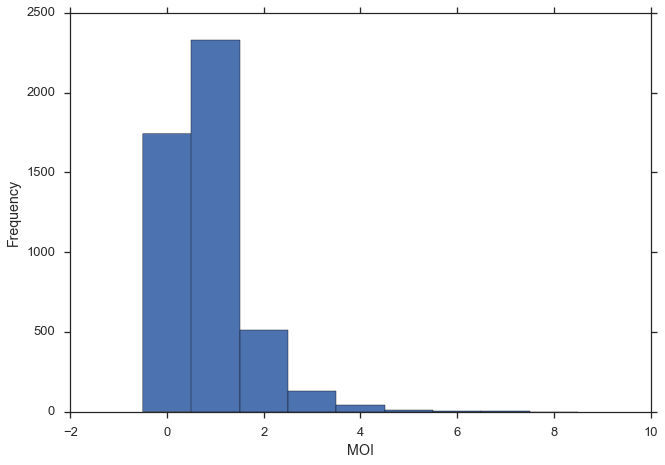

In [46]:
plt.hist(moi_list,np.arange(10)-0.5)
plt.xlabel('MOI')
plt.ylabel('Frequency')